In [1]:
import numpy as np
import SimpleITK as sitk
import os
import torch
import matplotlib.pyplot as plt

# set cuda visible devices
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

patient = 37 # 1-450
view = '4CH' # 2CH, 4CH

# Plotting functions

In [72]:
import cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from matplotlib.collections import LineCollection
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

def qualitative_evaluation(moving_img, fixed_img, warped_img):
    # 
    # Compute absolute difference
    res_moving = cv2.absdiff(fixed_img, moving_img)
    res_warped = cv2.absdiff(fixed_img, warped_img)

    # Generate figure with results
    fig, ax = plt.subplots(2, 3, figsize = (7.5, 5))
    ax[0,0].imshow(fixed_img, cmap='gray')
    ax[0,0].set_title('Fixed image')
    ax[0,1].imshow(moving_img, cmap='gray')
    ax[0,1].set_title('Average moving image')
    ax[0,2].imshow(warped_img, cmap='gray')
    ax[0,2].set_title('Average warped image')
    ax[1,1].imshow(res_moving, cmap='afmhot')
    ax[1,2].imshow(res_warped, cmap='afmhot')

    for a in ax.ravel():
        a.axis('off')

    plt.tight_layout()
    plt.show()
def compute_jacobian_determinant(dvf_np):
    """
    Compute the jacobian determinant of a displacement field
    Args:
        dvf_np: Displacement field of shape [2,H,W]
    Returns:
        jacobian: Jacobian determinant of shape [H,W]
        jacobian_masked: Masked jacobian determinant of shape [H,W] where the values are less than zero
    """
    #Convert the numpy array to a HxW image with each pixel being a 2D vector and compute the jacobian determinant volume
    sitk_displacement_field = sitk.GetImageFromArray(dvf_np.transpose(1,2,0), isVector=True)
    jacobian_det_volume = sitk.DisplacementFieldJacobianDeterminant(sitk_displacement_field)
    jacobian = sitk.GetArrayViewFromImage(jacobian_det_volume,).astype(np.float16)
    # Find the critical points, i.e. where the jacobian determinant is less than zero
    jacobian_masked = np.ma.masked_where((jacobian > 0), jacobian)

    return jacobian, jacobian_masked
def plot_jacobian_determinant(jacobian, jacobian_masked, ax=None, **kwargs):
    ax = ax or plt.gca()
    # Plot jacobian determinant
    im1 = ax.imshow(jacobian, cmap='PuOr', norm=mpl.colors.Normalize(vmin=0, vmax=2))
    # Plot critical points, i.e. where the jacobian determinant is less than zero
    im2 = ax.imshow(jacobian_masked, cmap='bwr', norm=mpl.colors.Normalize(vmin=-1e8, vmax=-1e7))
    # hide ticks
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    # Plot colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    plt.colorbar(im1, cax=cax, ticks=[0.0, 0.5, 1.0, 1.5, 2.0], orientation='horizontal')
    # Add title
    ax.set_title('Jacobian determinant')


Load sequence and extract two frames

In [3]:
patient_name = f'patient{patient:04d}'
vid_path = f'/home/mtarufo/thesis/supervision_by_registration/data/camus/training/{patient_name}/{patient_name}_{view}_sequence.mhd'
vid = sitk.ReadImage(vid_path)
vid = sitk.GetArrayFromImage(vid)
print(f'Patient: {patient_name} ({view})\nVideo shape: {vid.shape}')

Patient: patient0037 (4CH)
Video shape: (22, 1168, 708)


Given a fixed image and a moving image, a deformation field is predicted to warp the moving image and match the fixed image.
Therefore:
- Moving image: the image to be warped (frame $n$)
- Fixed image: the image to be matched (frame $n+1$)

In [4]:
moving_img = vid[0]
fixed_img = vid[10]

moving_img = torch.FloatTensor(moving_img)	
fixed_img = torch.FloatTensor(fixed_img)

In [5]:
from utils import general
from models import models

out_dir = "./CAMUS"

kwargs = {}
kwargs["verbose"] = False
kwargs["hyper_regularization"] = False
kwargs["jacobian_regularization"] = False
kwargs["bending_regularization"] = False
kwargs["network_type"] = "SIREN"  # Options are "MLP" and "SIREN"
kwargs["save_folder"] = os.path.join(out_dir, patient_name + '_' + view)
kwargs["mask"] = None
kwargs["batch_size"] = 1000
kwargs["omega"] = 32

ImpReg = models.ImplicitRegistrator(moving_img, fixed_img, **kwargs)
ImpReg.fit()

/home/mtarufo/anaconda3/envs/thesis/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 2500/2500 [00:16<00:00, 147.94it/s]


In [12]:
moving_mask = sitk.ReadImage(f'/home/mtarufo/thesis/supervision_by_registration/data/camus/training/{patient_name}/{patient_name}_{view}_ED_gt.mhd')
moving_mask = sitk.GetArrayFromImage(moving_mask)[0]
moving_mask = torch.FloatTensor(moving_mask)

In [41]:
def make_coordinate_tensor(dims=(28, 28)):
    """Make a coordinate tensor."""

    coordinate_tensor = [torch.linspace(-1, 1, dims[i]) for i in range(2)]
    coordinate_tensor = torch.meshgrid(*coordinate_tensor)
    coordinate_tensor = torch.stack(coordinate_tensor, dim=2)
    coordinate_tensor = coordinate_tensor.view([np.prod(dims), 2])

    coordinate_tensor = coordinate_tensor.cuda()

    return coordinate_tensor

coordinate_tensor = make_coordinate_tensor(dims=moving_img.shape)
coordinate_tensor_transformed = ImpReg.network(coordinate_tensor)

# Shift coordinates by 1/n * v
coord_temp = torch.add(coordinate_tensor_transformed, coordinate_tensor)


warped_mask = ImpReg(coordinate_tensor, moving_image = moving_mask.cuda(), output_shape = moving_img.shape).astype(np.uint8)
warped_img = ImpReg(coordinate_tensor, moving_image = moving_img.cuda(), output_shape = moving_img.shape).astype(np.uint8)

Converting output to DVF

In [59]:
x_indices, y_indices = coord_temp[:, 0],  coord_temp[:, 1],
input_array = np.zeros_like(moving_img)
x_indices = (x_indices + 1) * (input_array.shape[0] - 1) * 0.5
y_indices = (y_indices + 1) * (input_array.shape[1] - 1) * 0.5

x_indices = x_indices.reshape(input_array.shape).detach().cpu()
y_indices = y_indices.reshape(input_array.shape).detach().cpu()
# stack these two in the first dimension
displaced_grid = np.stack([x_indices, y_indices], axis=0)

# I think if I now subtract an identity grid, I get the dvf
identity_grid = np.indices(input_array.shape).astype(np.float32)
dvf = displaced_grid - identity_grid

Text(0.5, 1.0, 'Warped (moving) mask')

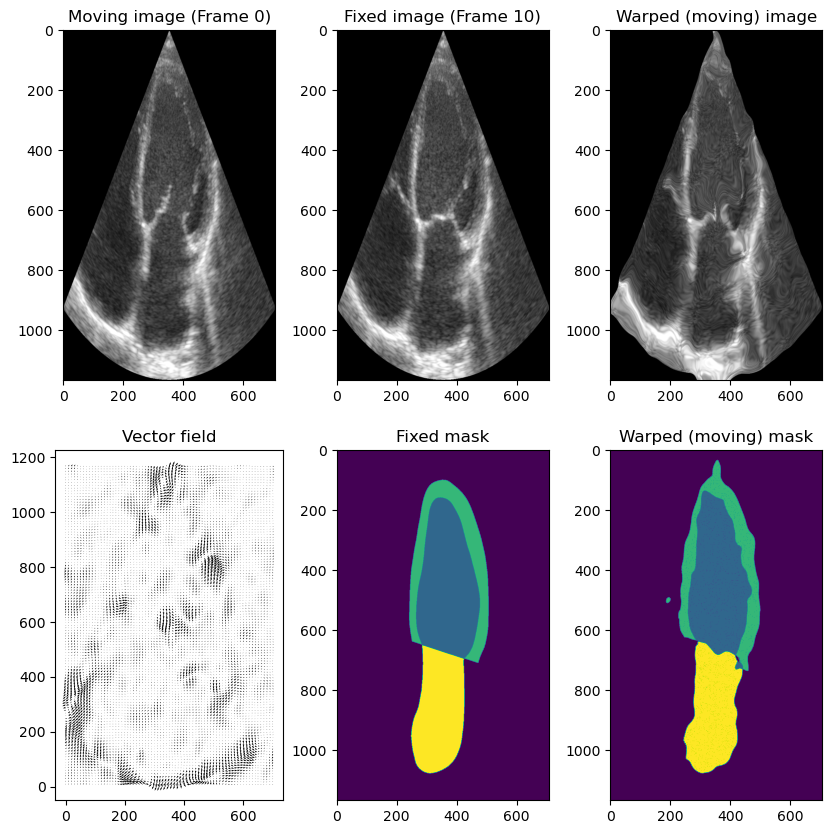

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0,0].imshow(moving_img, cmap='gray', vmin=0, vmax=255)
ax[0,0].set_title('Moving image (Frame 0)')
ax[0,1].imshow(fixed_img, cmap='gray', vmin=0, vmax=255)
ax[0,1].set_title('Fixed image (Frame 10)')
ax[0,2].imshow(warped_img, cmap='gray', vmin=0, vmax=255)
ax[0,2].set_title('Warped (moving) image')
step = 10 # to downsample the grid
x,y = np.meshgrid(np.arange(0, dvf.shape[2]), np.arange(dvf.shape[1],0,-1))
u,v = dvf[1], dvf[0]
ax[1,0].quiver(x[::step, ::step],y[::step, ::step],u[::step, ::step],v[::step, ::step])
ax[1,0].set_title('Vector field')
ax[1,1].imshow(moving_mask)
ax[1,1].set_title('Fixed mask')
ax[1,2].imshow(warped_mask)
ax[1,2].set_title('Warped (moving) mask')


In [61]:
dvf.shape

(2, 1168, 708)

In [105]:
def plot_grid(u,v, step = 10, ax=None, **kwargs):
    # as seen in https://stackoverflow.com/questions/47295473/how-to-plot-using-matplotlib-python-colahs-deformed-grid
    grid_x, grid_y = np.meshgrid(np.arange(0, u.shape[1], 1), np.arange(v.shape[0], 0, -1))
    f = lambda x, y : (x + u, y + v)
    distx, disty = f(grid_x, grid_y)

    ax = ax or plt.gca()
    segs1 = np.stack((distx[::step, ::step], disty[::step, ::step]), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

(1168, 708) (1168, 708) (1168, 708) (1168, 708)


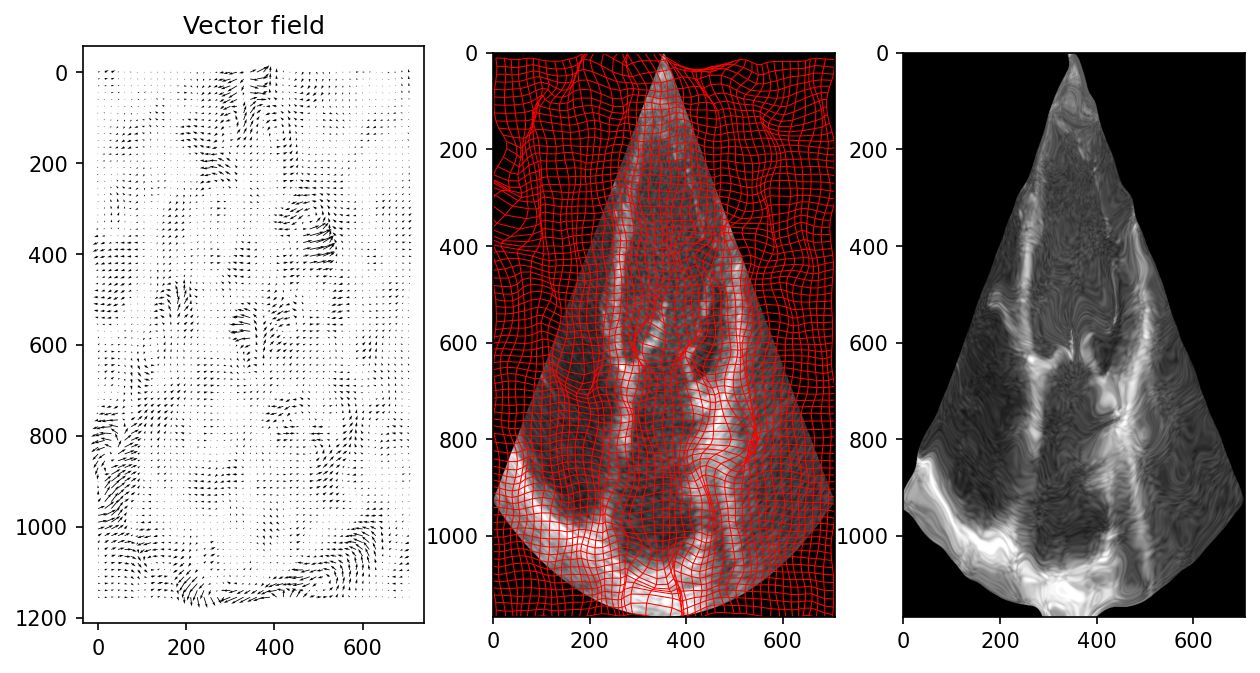

In [109]:
dvf_scaled = dvf / 2
step = 15 # to downsample the grid
x,y = np.meshgrid(np.arange(0, dvf.shape[2]), np.arange(0,dvf.shape[1]))

u,v = dvf_scaled[0], dvf_scaled[1]

print(u.shape, v.shape, x.shape, y.shape)

jacobian_1, jacobian_masked_1 = compute_jacobian_determinant(dvf)

# =============================================================================

fig, ax = plt.subplots(1, 3, figsize=(10,5), dpi=150)
ax[0].quiver(x[::step, ::step],y[::step, ::step],u[::step, ::step],v[::step, ::step])
ax[0].invert_yaxis()
ax[0].set_title('Vector field')
plot_grid(u, v, step=step, ax=ax[1], color="red", linewidth=0.5)
ax[1].imshow(moving_img, cmap='gray', vmin=0, vmax=255)
ax[2].imshow(warped_img, cmap='gray', vmin=0, vmax=255)
# ax[1].imshow(moving_img, cmap='gray', vmin=0, vmax=255)
# ax[1].set_title('Deformed grid')
# plot_jacobian_determinant(jacobian_1, jacobian_masked_1, ax=ax[2])
# ax[2].set_title('Jacobian determinant')

# for a in ax.ravel():
#     a.axis('off')

plt.show()
